In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imsave
import cPickle as pickle
import yaml
import collections
from tqdm import tqdm
import time
from scipy.ndimage.interpolation import zoom

# Loading and interpreting results

In [81]:
import h5py
h5path = base + '/results/master/predictions/golden_model_second_3_2.h5'
f = h5py.File(h5path)

In [82]:
res = np.array(f['results'])
res.shape
fname_to_res = {fname.split('.')[0]:r for fname, r in zip(fnames, res)}

In [83]:
names = [fname.split('.')[0] for fname in fnames]
orig_fnames = set('_'.join(name.split('_')[:-1]) for name in names)

In [122]:
aggragated_preds = {}

for orig_fname in orig_fnames:
    
    this_res = np.zeros(60-10)
    for start_time in range(0, 60-10):
        
        name = orig_fname + '_%04d' % start_time        
        
        # note - assuming one second gaps
        this_res[start_time] = fname_to_res[name]
        
    aggragated_preds[orig_fname] = np.zeros_like(this_res)

    for idx in range(len(this_res)):

        start_idx = max(idx-9, 0)
        end_idx = idx
        preds_for_this_moment = this_res[start_idx:end_idx+1]

        aggragated_preds[orig_fname][idx] = \
            np.min(preds_for_this_moment)

# Plotting results with ground truth

In [123]:
# load gt
gts = {}
gt_dir = '/media/michael/Engage/data/audio/alison_data/golden_set/extracted/annotations/'
for fname in aggragated_preds:
    gts[fname] = pickle.load(open(gt_dir + fname + '.pkl'))[0]['biotic']

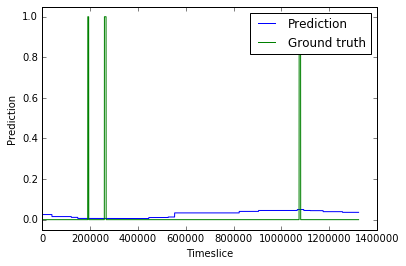

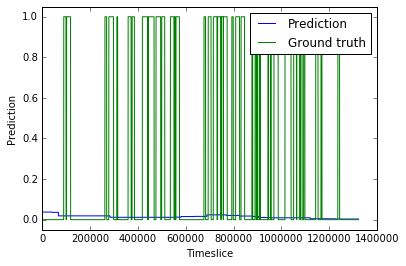

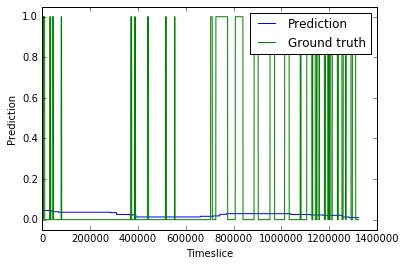

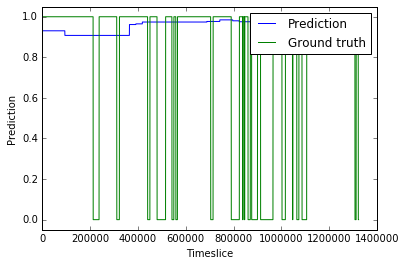

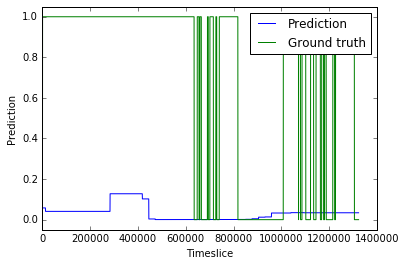

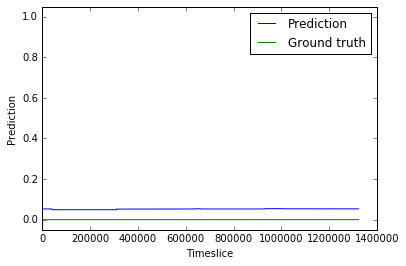

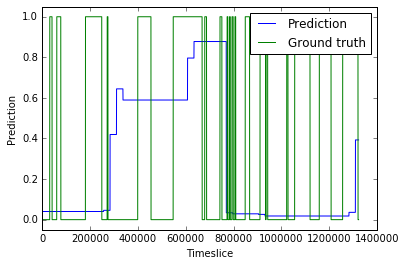

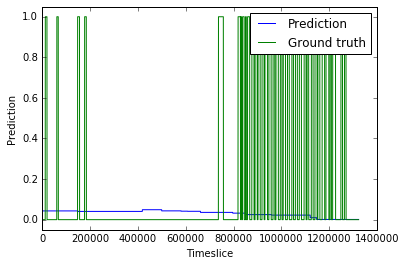

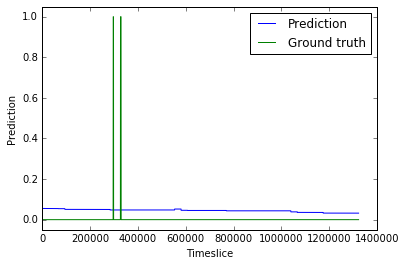

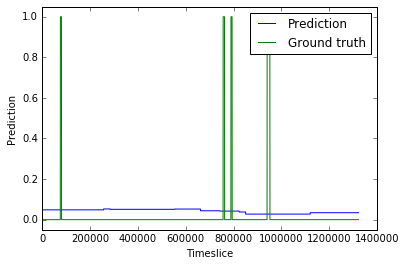

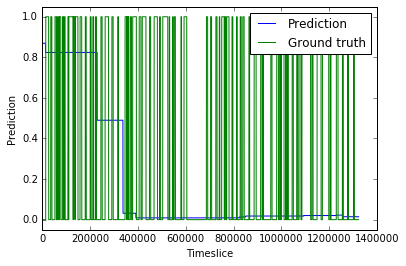

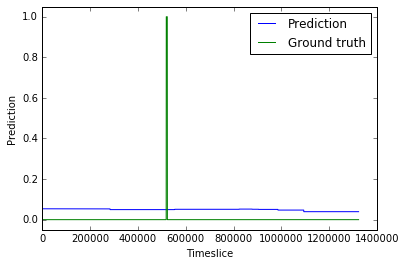

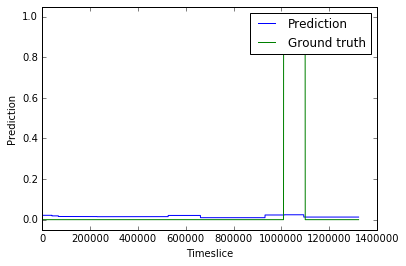

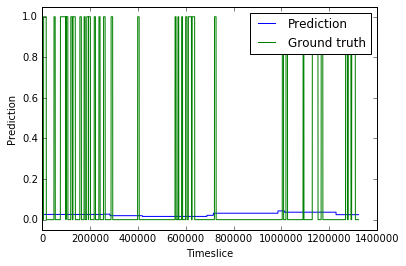

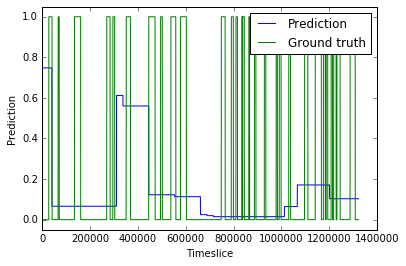

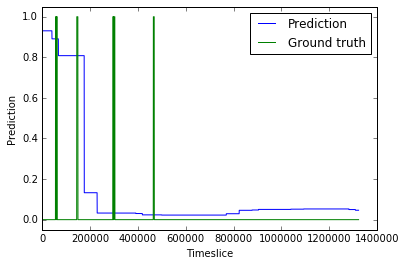

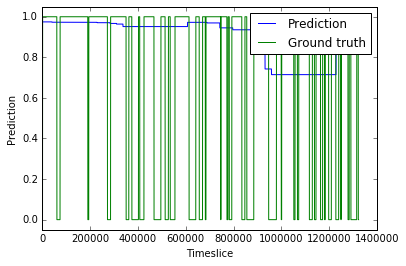

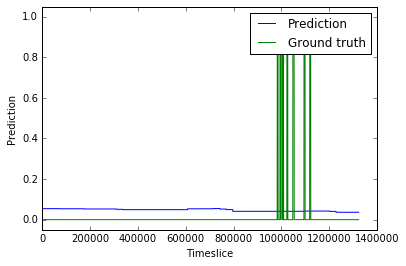

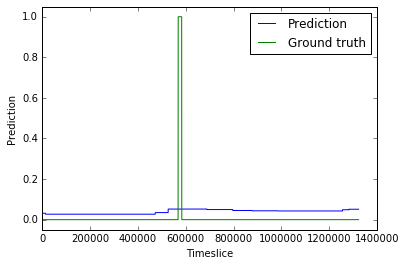

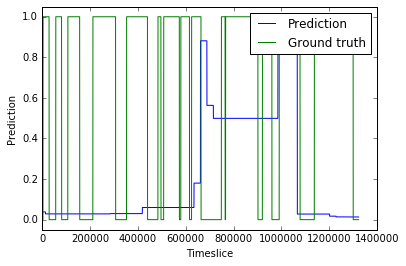

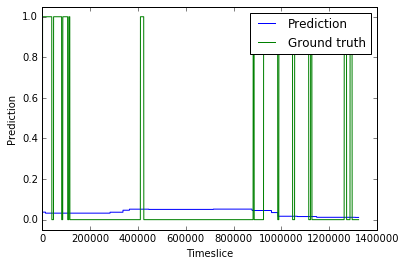

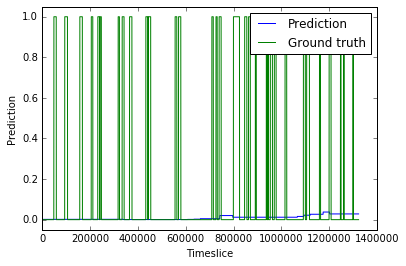

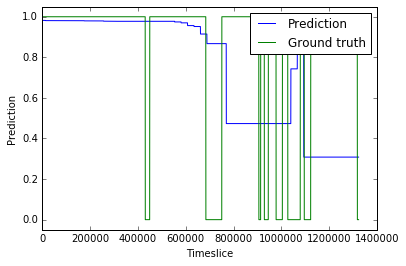

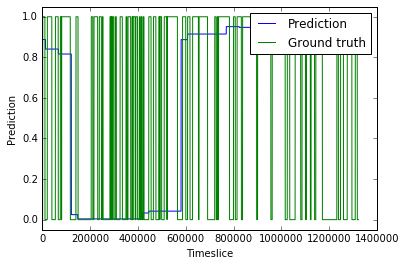

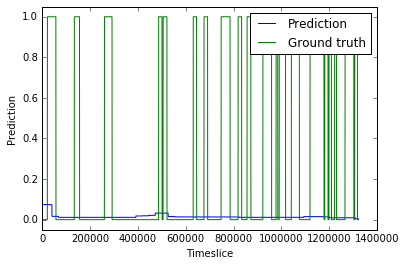

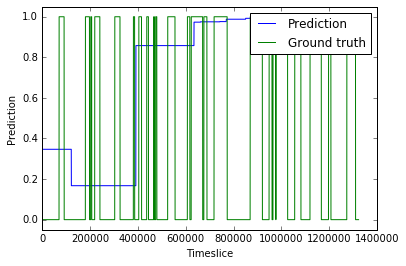

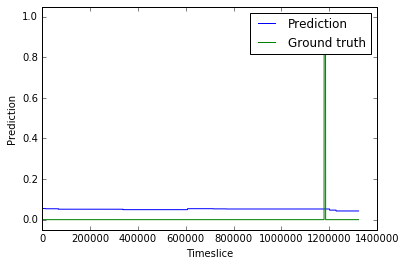

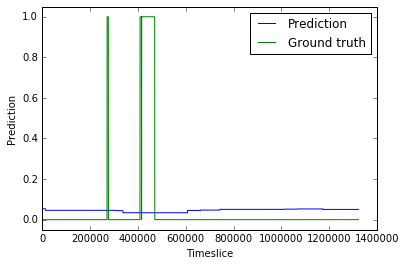

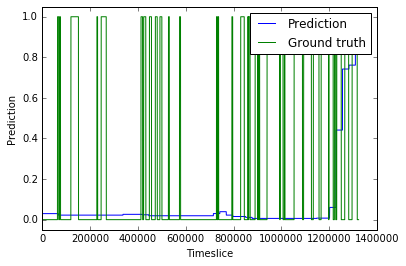

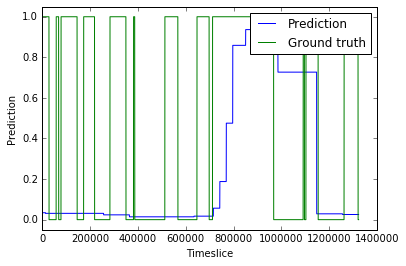

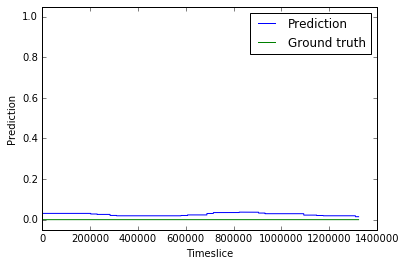

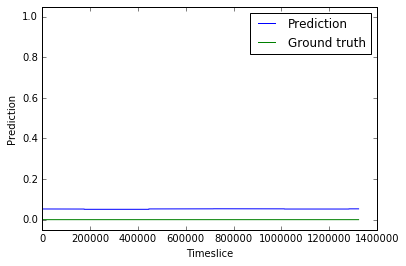

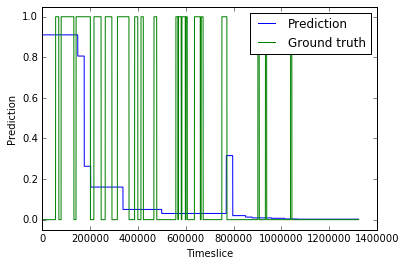

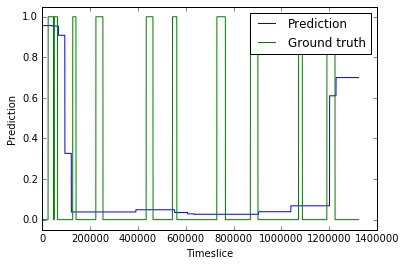

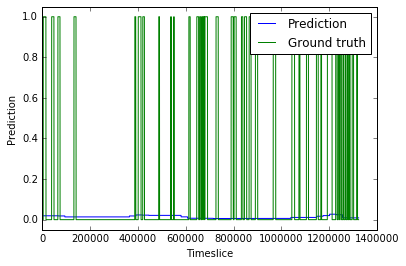

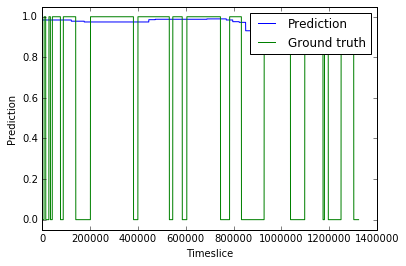

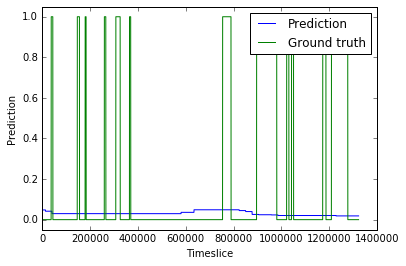

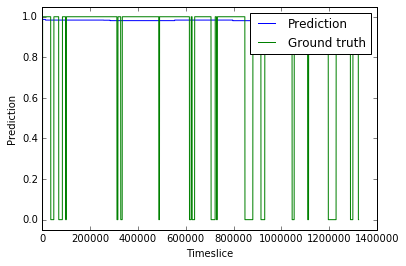

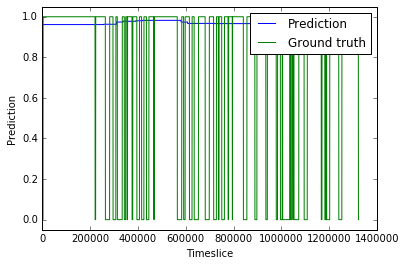

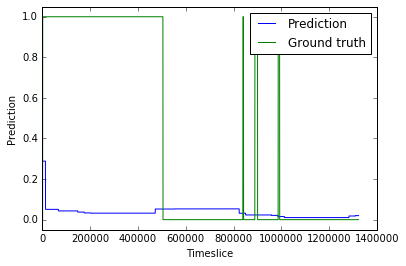

In [124]:
for fname in aggragated_preds:
    plt.figure()

    # plot predicted
    factor = gts[fname].shape[0] / float(aggragated_preds[fname].shape[0])
    pred = zoom(aggragated_preds[fname], factor, order=0)
    plt.plot(pred, label='Prediction')
    
    # plot ground truth
    
    plt.plot(gts[fname], label='Ground truth')
    
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Timeslice')
    plt.ylabel('Prediction')
    plt.legend()

In [125]:
all_preds = []
all_gts = []

for fname in aggragated_preds:

    # plot predicted
    factor = gts[fname].shape[0] / float(aggragated_preds[fname].shape[0])
    pred = zoom(aggragated_preds[fname], factor, order=0)
    
    gts[fname]
    
    all_preds.append(pred)
    all_gts.append(gts[fname])
    
all_preds = np.round(np.hstack(all_preds))
all_gts = np.round(np.hstack(all_gts))

accuracy = np.mean(all_preds == all_gts)
print accuracy

0.769368907752


In [126]:
# class balanced
A = np.mean(all_preds[all_gts > 0.5] == all_gts[all_gts > 0.5])
B = np.mean(all_preds[all_gts < 0.5] == all_gts[all_gts < 0.5])
print (A + B) / 2.0

0.684316579501
